## LED Model Fine Tuning 


### 1) **3 Ways to Fine Tune Model**

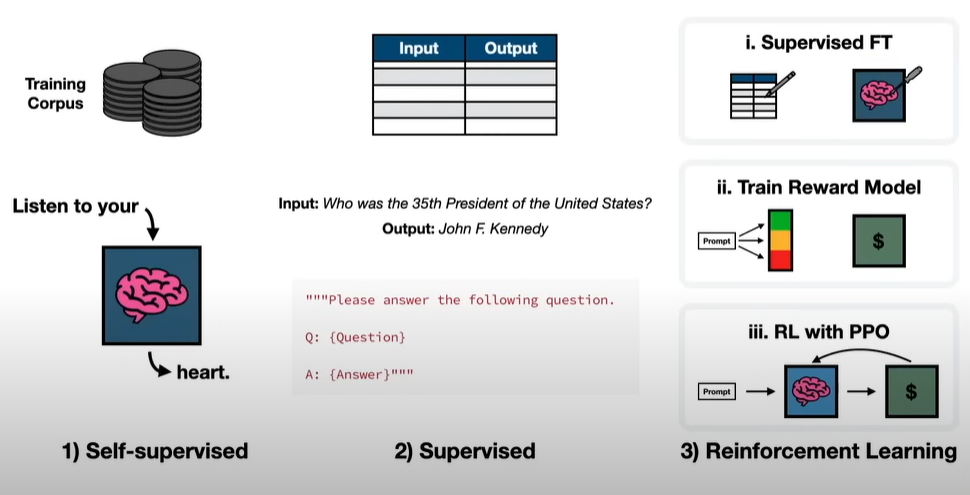

I will choose 2nd Option (**Supervised**) as the fine-tuning method, since we have labeled data related to our task.

#### Benefit:

- **Task-Specific Performance**:  Have similar labeled data directly related to your task
- **Efficiency**: It usually requires less computational effort and time compared to self-supervised or reinforcement learning approaches


#### Steps to Supervised Fine-Tuning:

1. Choose fine-tuning task

2. Prepare training dataset

3. Choose a base model

4. Fine-tune model via supervised learning

5. Evaluate model performance


### 2) **3 Options for Parameter Training**

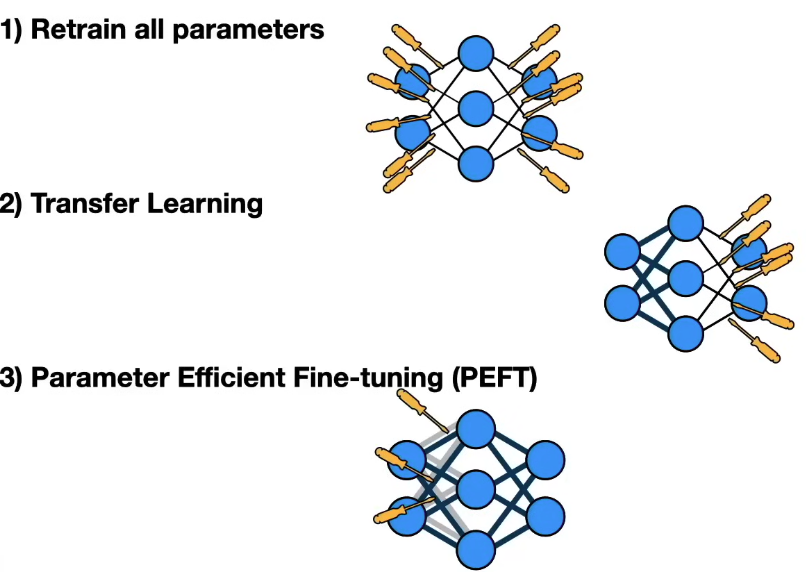

| Approach                          | Description                                                                                       | Pros                                                                                                              | Cons                                                                                                              |
|-----------------------------------|---------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------|
| **Retrain All Parameters**            | Retraining the entire model from scratch using randomly initialized or pre-trained weights         | - Learns task-specific features from scratch<br>- Flexibility in learning entirely new representations       | - Requires substantial labeled data<br>- High computational resources<br>- Potentially slower convergence           |
| **Transfer Learning**                 | Leveraging pre-trained models and fine-tuning specific upper layers on a new task or dataset       | - Utilizes pre-trained knowledge<br>- Faster convergence compared to training from scratch<br>- Less data required | - Might not capture specific task nuances<br>- Relies on similarity between pre-training and target task             |
| **Parameter Efficient Fine-Tuning (PEFT)**    | Selectively updating specific model parameters or layers, adapting updates based on task relevance | - Optimizes computational resources<br>- Focuses updates on relevant parameters                                    | - Requires careful design for selective parameter updates<br>- Might need domain expertise for optimal adjustments |

#### What is **LoRA**?

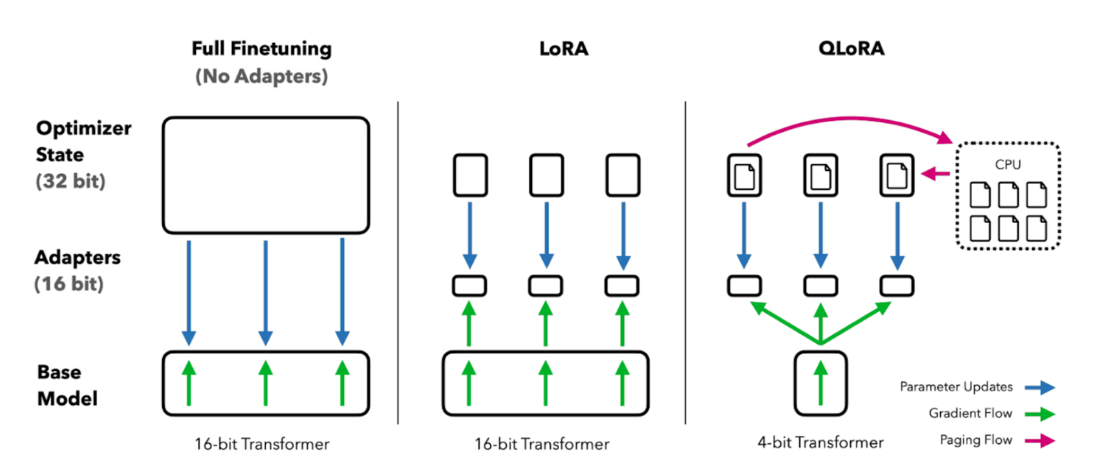

**Low-rank adaptation (LoRA) / Quantized Low-rank adaptation (QLoRA)** is a technique used in model compression or **parameter-efficient fine-tuning (PEFT)** methods. It involves reducing the rank of weight matrices in neural networks to make them more parameter-efficient while maintaining performance.




**References**

https://www.youtube.com/watch?v=eC6Hd1hFvos

https://www.mercity.ai/blog-post/guide-to-fine-tuning-llms-with-lora-and-qlora

https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms

In [1]:
####

In [2]:
# !pip install transformers
# !pip install transformers[torch]
# !pip install tensorboard
# !pip install peft
# !pip install torch
# !pip install -q -u bitsandbytes

In [3]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer ,LEDForConditionalGeneration, LEDTokenizer
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

from peft import PeftModel, PeftConfig, LoraConfig, TaskType
from peft import get_peft_model,  prepare_model_for_kbit_training, prepare_model_for_int8_training

import pandas as pd
import torch
from datasets import load_dataset, load_from_disk, Dataset, DatasetDict

c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(torch.__version__)
torch.cuda.is_available()

2.1.1+cpu


False

In [5]:
# torch.zeros(1).cuda()

In [6]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# print(count_trainable_params(model), count_trainable_params(lora_model))

In [7]:
# Tokenize Data
def preprocess_function(sample):
    # tokenize inputs
    sample['input_ids'] = tokenizer(sample["transcript"], padding="max_length", truncation=True, return_tensors='pt').input_ids

    # Tokenize targets with the `text_target` keyword argument
    sample['labels'] = tokenizer(text_target=sample["summary"], padding="max_length", truncation=True, return_tensors='pt').input_ids

    
    return sample

In [8]:
df_train = pd.read_excel('../Data/tib_train.xlsx')
df_test = pd.read_excel('../Data/tib_test.xlsx')

df_train["id"] = df_train.index 
df_test["id"] = df_test.index + len(df_train)


# Convert DataFrames into Datasets
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

# Create a DatasetDict to contain train and test splits
datasets = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
})

# Access information about the combined dataset
for split_name, split_dataset in datasets.items():
    print(f"{split_name}: {split_dataset.info}")

print(datasets.keys())

train: DatasetInfo(description='', citation='', homepage='', license='', features={'summary': Value(dtype='string', id=None), 'transcript': Value(dtype='string', id=None), 'id': Value(dtype='int64', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)
test: DatasetInfo(description='', citation='', homepage='', license='', features={'summary': Value(dtype='string', id=None), 'transcript': Value(dtype='string', id=None), 'id': Value(dtype='int64', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)
dict_keys(['train', 'test'])


In [9]:
# def print_trainable_parameters(model):
#     """
#     Prints the number of trainable parameters in the model.
#     """
#     trainable_params = 0
#     all_param = 0
#     for _, param in model.named_parameters():
#         all_param += param.numel()
#         if param.requires_grad:
#             trainable_params += param.numel()
#     print(
#         f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
#     )

In [10]:
led_based_model = AutoModelForSeq2SeqLM.from_pretrained("pszemraj/led-base-book-summary")
led_based_tokenizer = AutoTokenizer.from_pretrained("pszemraj/led-base-book-summary")


# led_large_model = AutoModelForSeq2SeqLM.from_pretrained("pszemraj/led-large-book-summary")
# led_large_tokenizer = AutoTokenizer.from_pretrained("pszemraj/led-large-book-summary")


# led_distil_model = LEDForConditionalGeneration.from_pretrained("HHousen/distil-led-large-cnn-16384")
# led_distil_tokenizer = LEDTokenizer.from_pretrained("HHousen/distil-led-large-cnn-16384")


# led_t5_model = AutoModelForSeq2SeqLM.from_pretrained("pszemraj/long-t5-tglobal-base-16384-book-summary")
# led_t5_tokenizer = AutoTokenizer.from_pretrained("pszemraj/long-t5-tglobal-base-16384-book-summary")

In [11]:
print("led_based_model size: ", led_based_model.num_parameters())
# print("led_large_model size: ", led_large_model.num_parameters())
# print("led_distil_model size: ", led_distil_model.num_parameters())
# print("led_t5_model size: ", led_t5_model.num_parameters())

led_based_model size:  161844480


In [12]:
print("led_based_tokenizer:", led_based_tokenizer.model_max_length)
# print("led_large_tokenizer:", led_large_tokenizer.model_max_length)
# print("led_distil_tokenizer:", led_distil_tokenizer.model_max_length)
# print("led_t5_tokenizer:", led_t5_tokenizer.model_max_length)

led_based_tokenizer: 16384


### Load Training Data

In [13]:
model = led_based_model
tokenizer = led_based_tokenizer

In [14]:
df_train = pd.read_excel('../Data/tib_train.xlsx')
df_test = pd.read_excel('../Data/tib_test.xlsx')

df_train["id"] = df_train.index 
df_test["id"] = df_test.index + len(df_train)


# Convert DataFrames into Datasets
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

# Create a DatasetDict to contain train and test splits
datasets = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
})

# Access information about the combined dataset
for split_name, split_dataset in datasets.items():
    print(f"{split_name}: {split_dataset.info}")

print(datasets.keys())

train: DatasetInfo(description='', citation='', homepage='', license='', features={'summary': Value(dtype='string', id=None), 'transcript': Value(dtype='string', id=None), 'id': Value(dtype='int64', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)
test: DatasetInfo(description='', citation='', homepage='', license='', features={'summary': Value(dtype='string', id=None), 'transcript': Value(dtype='string', id=None), 'id': Value(dtype='int64', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)
dict_keys(['train', 'test'])


In [15]:
tokenizer.pad_token = tokenizer.eos_token

tokenized_dataset = datasets.map(
        preprocess_function,
        batched=True,
    )


tokenized_dataset = tokenized_dataset.remove_columns(["transcript", "summary", "id"])

# for split in tokenized_dataset.keys():
    # tokenized_dataset[split] = tokenized_dataset[split].remove_columns(["transcript", "summary", "id"])

# tokenized_dataset = tokenized_dataset.remove_column(["transcript", "summary", "id"])
# tokenized_dataset = tokenized_dataset.rename_column= ["label", "labels"]
# tokenized_dataset = tokenized_dataset.with_format("torch")


# # save datasets to disk for later easy loading
tokenized_dataset["train"].save_to_disk("./data/train")
tokenized_dataset["test"].save_to_disk("./data/eval")

tokenized_dataset

Saving the dataset (1/1 shards): 100%|██████████| 35/35 [00:00<00:00, 5522.77 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 241
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 35
    })
})

In [16]:
print(len(tokenized_dataset['train']['input_ids'][10]))
print(len(tokenized_dataset['train']['labels'][10]))

16384
16384


In [17]:


tokenized_dataset_train = load_from_disk("data/train")
tokenized_dataset_test = load_from_disk("data/eval")

### Fine Tuning

#### LED Based Model

In [18]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
# Define LoRA Config
lora_config = LoraConfig(
    r=16,
    lora_alpha=8,
    target_modules=["query", "value"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)


model = get_peft_model(model, lora_config)
model.to(device)
model.print_trainable_parameters()

cpu
trainable params: 294,912 || all params: 162,139,392 || trainable%: 0.1818879399769798


In [23]:
output_dir="tuned_led-cnn-16384"

# Define training arguments
# training_args = Seq2SeqTrainingArguments(
#     output_dir=output_dir,
# 	auto_find_batch_size=False, # changed to false to run on GPU https://huggingface.co/google/flan-ul2/discussions/16s
#     per_device_train_batch_size=2,
#     per_device_eval_batch_size=2,
#     learning_rate=1e-3, # higher learning rate
#     num_train_epochs=5,
#     logging_dir=f"{output_dir}/logs",
#     logging_strategy="steps",
#     logging_steps=500,
#     save_strategy="no",
#     report_to="tensorboard",
# )

training_args = Seq2SeqTrainingArguments(
                    output_dir=output_dir,
                    num_train_epochs=2,
                    learning_rate=2e-5,
                    per_device_train_batch_size=2,
                    weight_decay=0.01,
                    evaluation_strategy='epoch',
                    disable_tqdm=False,
                    logging_steps=500,
                    push_to_hub=False,
                    log_level='error'
                    )

# label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer = tokenizer,
    model=model,
    # label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

# Define Trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer= tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset_train,
    # eval_dataset= tokenized_dataset_test
)

torch.cuda.empty_cache()
model.config.use_cache = False


In [24]:
trainer.train()

  0%|          | 0/242 [00:00<?, ?it/s]

: 